## 探索数据

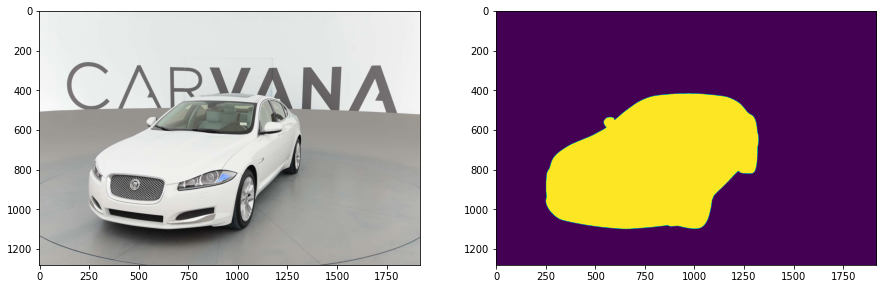

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import random

def rle_encode(mask_rle, shape=(1280, 1918)):
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0::2], s[1::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)

bPath = '/datadisk/kg/kg_solutions/Kaggle-Carvana-Image-Masking-Challenge/input/'

rle_csv = pd.read_csv(os.path.join(bPath, 'train_masks.csv'))
imgs = rle_csv['img']
rle_masks = rle_csv['rle_mask']

idx = random.randint(0, len(imgs))
si, sm = imgs[idx], rle_masks[idx]
si = os.path.join(bPath, 'train', si)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 30))
axes[0].imshow(cv2.imread(si))
axes[1].imshow(rle_encode(sm))

## 训练模型

In [13]:
import cv2
import numpy as np
import pandas as pd
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from sklearn.model_selection import train_test_split
from model.u_net import get_unet_128, get_unet_256, get_unet_512, get_unet_1024

# from tensorflow.compat.v1 import ConfigProto
# from tensorflow.compat.v1 import InteractiveSession

# config = ConfigProto()
# config.gpu_options.allow_growth = True
# session = InteractiveSession(config=config)

input_size = 256
epochs = 100
batch_size = 1
model = get_unet_256()

df_train = pd.read_csv('input/train_masks.csv')
# 这是dataframe series自己的map 直接把每个元素map
ids_train = df_train['img'].map(lambda s: s.split('.')[0])

ids_train_split, ids_valid_split = train_test_split(ids_train, test_size=0.2, random_state=42)

print('Training on {} samples'.format(len(ids_train_split)))
print('Validating on {} samples'.format(len(ids_valid_split)))

def randomHueSaturationValue(image, hue_shift_limit=(-180, 180),
                             sat_shift_limit=(-255, 255),
                             val_shift_limit=(-255, 255), u=0.5):
    if np.random.random() < u:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        h, s, v = cv2.split(image)
        hue_shift = np.random.uniform(hue_shift_limit[0], hue_shift_limit[1])
        h = cv2.add(h, hue_shift)
        sat_shift = np.random.uniform(sat_shift_limit[0], sat_shift_limit[1])
        s = cv2.add(s, sat_shift)
        val_shift = np.random.uniform(val_shift_limit[0], val_shift_limit[1])
        v = cv2.add(v, val_shift)
        image = cv2.merge((h, s, v))
        image = cv2.cvtColor(image, cv2.COLOR_HSV2BGR)

    return image

def randomShiftScaleRotate(image, mask,
                           shift_limit=(-0.0625, 0.0625),
                           scale_limit=(-0.1, 0.1),
                           rotate_limit=(-45, 45), aspect_limit=(0, 0),
                           borderMode=cv2.BORDER_CONSTANT, u=0.5):
    if np.random.random() < u:
        height, width, channel = image.shape

        angle = np.random.uniform(rotate_limit[0], rotate_limit[1])  # degree
        scale = np.random.uniform(1 + scale_limit[0], 1 + scale_limit[1])
        aspect = np.random.uniform(1 + aspect_limit[0], 1 + aspect_limit[1])
        sx = scale * aspect / (aspect ** 0.5)
        sy = scale / (aspect ** 0.5)
        dx = round(np.random.uniform(shift_limit[0], shift_limit[1]) * width)
        dy = round(np.random.uniform(shift_limit[0], shift_limit[1]) * height)

        cc = np.math.cos(angle / 180 * np.math.pi) * sx
        ss = np.math.sin(angle / 180 * np.math.pi) * sy
        rotate_matrix = np.array([[cc, -ss], [ss, cc]])

        box0 = np.array([[0, 0], [width, 0], [width, height], [0, height], ])
        box1 = box0 - np.array([width / 2, height / 2])
        box1 = np.dot(box1, rotate_matrix.T) + np.array([width / 2 + dx, height / 2 + dy])

        box0 = box0.astype(np.float32)
        box1 = box1.astype(np.float32)
        # 得到两个box之间的变换矩阵
        mat = cv2.getPerspectiveTransform(box0, box1)
        # 应用这种变换得到校准之后的image https://blog.csdn.net/guduruyu/article/details/72518340
        image = cv2.warpPerspective(image, mat, (width, height), flags=cv2.INTER_LINEAR, borderMode=borderMode,
                                    borderValue=(
                                        0, 0,
                                        0,))
        mask = cv2.warpPerspective(mask, mat, (width, height), flags=cv2.INTER_LINEAR, borderMode=borderMode,
                                   borderValue=(
                                       0, 0,
                                       0,))

    return image, mask


def randomHorizontalFlip(image, mask, u=0.5):
    if np.random.random() < u:
        image = cv2.flip(image, 1)
        mask = cv2.flip(mask, 1)

    return image, mask


def train_generator():
    while True:
        for start in range(0, len(ids_train_split), batch_size):
            x_batch = []
            y_batch = []
            end = min(start + batch_size, len(ids_train_split))
            ids_train_batch = ids_train_split[start:end]
            for id in ids_train_batch.values:
                img = cv2.imread('input/train/{}.jpg'.format(id))
                img = cv2.resize(img, (input_size, input_size))
                mask = cv2.imread('input/train_masks/{}_mask.png'.format(id), cv2.IMREAD_GRAYSCALE)
                mask = cv2.resize(mask, (input_size, input_size))
                img = randomHueSaturationValue(img,
                                               hue_shift_limit=(-50, 50),
                                               sat_shift_limit=(-5, 5),
                                               val_shift_limit=(-15, 15))
                img, mask = randomShiftScaleRotate(img, mask,
                                                   shift_limit=(-0.0625, 0.0625),
                                                   scale_limit=(-0.1, 0.1),
                                                   rotate_limit=(-0, 0))
                img, mask = randomHorizontalFlip(img, mask)
                mask = np.expand_dims(mask, axis=2)
                x_batch.append(img)
                y_batch.append(mask)
            x_batch = np.array(x_batch, np.float32) / 255
            y_batch = np.array(y_batch, np.float32) / 255
            yield x_batch, y_batch


def valid_generator():
    while True:
        for start in range(0, len(ids_valid_split), batch_size):
            x_batch = []
            y_batch = []
            end = min(start + batch_size, len(ids_valid_split))
            ids_valid_batch = ids_valid_split[start:end]
            for id in ids_valid_batch.values:
                img = cv2.imread('input/train/{}.jpg'.format(id))
                img = cv2.resize(img, (input_size, input_size))
                mask = cv2.imread('input/train_masks/{}_mask.png'.format(id), cv2.IMREAD_GRAYSCALE)
                mask = cv2.resize(mask, (input_size, input_size))
                mask = np.expand_dims(mask, axis=2)
                x_batch.append(img)
                y_batch.append(mask)
            x_batch = np.array(x_batch, np.float32) / 255
            y_batch = np.array(y_batch, np.float32) / 255
            yield x_batch, y_batch


callbacks = [EarlyStopping(monitor='val_loss',
                           patience=8,
                           verbose=1,
                           min_delta=1e-4),
             ReduceLROnPlateau(monitor='val_loss',
                               factor=0.1,
                               patience=4,
                               verbose=1,
                               epsilon=1e-4),
             ModelCheckpoint(monitor='val_loss',
                             filepath='weights/best_weights.hdf5',
                             save_best_only=True,
                             save_weights_only=True),
             TensorBoard(log_dir='logs')]

model.fit_generator(generator=train_generator(),
                    steps_per_epoch=np.ceil(float(len(ids_train_split)) / float(batch_size)),
                    epochs=epochs,
                    verbose=2,
                    callbacks=callbacks,
                    validation_data=valid_generator(),
                    validation_steps=np.ceil(float(len(ids_valid_split)) / float(batch_size)))


Training on 4070 samples
Validating on 1018 samples
Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/100
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
4070/4070 - 229s - loss: 0.1178 - dice_coeff: 0.9289 - val_loss: 0.0302 - val_dice_coeff: 0.9848
Epoch 2/100
4070/4070 - 216s - loss: 0.0266 - dice_coeff: 0.9868 - val_loss: 0.0300 - val_dice_coeff: 0.9860
Epoch 3/100
4070/4070 - 219s - loss: 0.0224 - dice_coeff: 0.9889 - val_loss: 0.0179 - val_dice_coeff: 0.9909
Epoch 4/100
4070/4070 - 215s - loss: 0.0205 - dice_coeff: 0.9899 - val_loss: 0.0280 - val_dice_coeff: 0.9874
Epoch 5/100
4070/4070 - 212s - loss: 0.0192 - dice_coeff: 0.9905 - val_loss: 0.1081 - val_dice_coeff: 0.9666
Epoch 6/100
4070/4070 - 212s - loss: 0.0182 - dice_coeff: 0.9909 - val_loss: 0.0160 - val_dice_coeff: 0.9917
Epoch 7/100
4070/4070 - 212s - loss: 0.0177 - dice_coeff: 0.9912 - val_loss: 0.0178 - val_dice_coeff: 0.9911
Epoch 8/100
4070/4070 - 211s - loss: 

## Inference

In [22]:
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

input_size = 256
batch_size = 16
orig_width = 1918
orig_height = 1280
threshold = 0.5
model = get_unet_256()

df_test = pd.read_csv('input/sample_submission.csv')
ids_test = df_test['img'].map(lambda s: s.split('.')[0])

names = []
for id in ids_test:
    names.append('{}.jpg'.format(id))


# https://www.kaggle.com/stainsby/fast-tested-rle
def rle_encode(mask):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    inds = mask.flatten()
    runs = np.where(inds[1:] != inds[:-1])[0] + 2
    runs[1::2] = runs[1::2] - runs[:-1:2]
    rle = ' '.join([str(r) for r in runs])
    return rle


rles = []

model.load_weights('weights/best_weights.hdf5')

print('Predicting on {} samples with batch_size = {}...'.format(len(ids_test), batch_size))
for start in tqdm(range(0, len(ids_test), batch_size)):
    x_batch = []
    end = min(start + batch_size, len(ids_test))
    ids_test_batch = ids_test[start:end]
    for id in ids_test_batch.values:
        img = cv2.imread('input/test/{}.jpg'.format(id))
        img = cv2.resize(img, (input_size, input_size))
        x_batch.append(img)
    x_batch = np.array(x_batch, np.float32) / 255
    preds = model.predict_on_batch(x_batch)
    preds = np.squeeze(preds, axis=3)
    for pred in preds:
        prob = cv2.resize(pred, (orig_width, orig_height))
        mask = prob > threshold
        rle = rle_encode(mask)
        rles.append(rle)

print("Generating submission file...")
df = pd.DataFrame({'img': names, 'rle_mask': rles})
df.to_csv('submit/submission.csv.gz', index=False, compression='gzip')

  0%|          | 0/6254 [00:00<?, ?it/s]

Predicting on 100064 samples with batch_size = 16...


100%|██████████| 6254/6254 [40:33<00:00,  2.57it/s]


Generating submission file...


## 可视化test dataset

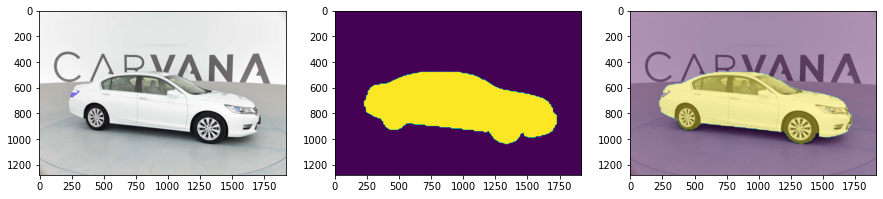

In [21]:
import os
import cv2
import matplotlib.pyplot as plt
import random
import numpy as np

def rle_decode(mask_rle, shape):
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0::2], s[1::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)

index = random.randint(0, df.shape[0])
sample = df.iloc[index, :]
imgName, rle_mask = sample['img'], sample['rle_mask']

imgPath = '/datadisk/kg/kg_solutions/Kaggle-Carvana-Image-Masking-Challenge/input/test/{}'.format(imgName)
img = cv2.imread(imgPath)

mask_img = rle_decode(rle_mask, shape=img.shape[:-1])

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 40))
axes[0].imshow(img)
axes[1].imshow(mask_img)
axes[2].imshow(img)
axes[2].imshow(mask_img, alpha=0.4)